In [1]:
import pandas as pd
import requests, warnings

In [2]:
import statsmodels.api as sm

In [3]:
from sklearn import preprocessing

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
min_max_scaler = preprocessing.MinMaxScaler()

In [6]:
def ag_get_data(query):
    warnings.simplefilter('ignore', requests.packages.urllib3.exceptions.InsecureRequestWarning)
    params = {"Database": "OIL", "Query": query}
    resp = requests.post('https://TST-QDEV-AP1.petroineos.local:5001/genericdata/Fetch/', json=params, verify=False)
    json_result = resp.json()
    df = pd.DataFrame(json_result)
    return df

In [7]:
unit_level = 'CDU'

In [8]:
IIR_Countries = ['Austria','Belgium','Denmark','Finland','France','Germany','Greece','Ireland','Italy','Netherlands','Norway','Portugal','Spain','Sweden','United Kingdom','Turkey','Czech Republic','Hungary','Poland','Slovakia','Switzerland']

In [9]:
NWE_countries = ['Belgium','Denmark','Finland','Germany','Ireland','Netherlands','Norway','Sweden','United Kingdom','France']

MED_countries = ['Austria','Czech Republic','Greece','Hungary','Italy','Poland','Portugal','Slovakia','Spain','Switzerland','Turkey']

In [10]:
country_list = IIR_Countries

In [11]:
def get_nameplate_capacity_monthly():
    total_cap_qry = f"select Unit_ID, DDate, Capacity, UNIT_GROUP, COUNTRY from oil.Refinery.RefineryUnitCapacityMonthly where UNIT_GROUP='{unit_level}'"
    total_cap = ag_get_data(total_cap_qry)
    total_cap_eu = total_cap[total_cap['COUNTRY'].isin(country_list)].copy()
    total_cap_eu['DDate'] = pd.to_datetime(total_cap_eu['DDate'])
    total_cap_eu['OUTAGE_DATE'] = total_cap_eu['DDate'].dt.to_period('M')
    return total_cap_eu

In [12]:
def get_mechanical_outages():
    outages_qry = "select * from oil.refinery.MaintenanceDaily where PDate = (select max(PDate) from oil.refinery.MaintenanceDaily)"
    outage_cause_qry = "select EVENT_ID, EVENT_TYPE, E_CAUSE from oil.Refinery.RefineryMaintenanceBestLatest"
    outages = ag_get_data(outages_qry)
    causes = ag_get_data(outage_cause_qry)
    outage_causes = outages.merge(causes, how='left', on='EVENT_ID')
    forced_outages = outage_causes[outage_causes['E_CAUSE']!='Economic']
    return forced_outages

In [13]:
def convert_to_monthly(df):
    df['OUTAGE_DATE'] = pd.to_datetime(df['OUTAGE_DATE'])
    forced_outages_monthly = df.groupby(['UNIT_ID', df.OUTAGE_DATE.dt.to_period('M')]).sum().reset_index()
    forced_outages_monthly['days'] = forced_outages_monthly.OUTAGE_DATE.dt.daysinmonth
    forced_outages_monthly['kbd_offline'] = forced_outages_monthly['CAP_OFFLINE']/forced_outages_monthly['days']
    forced_outages_monthly['kbd_offline'] = forced_outages_monthly['kbd_offline'].astype(int)
    forced_outages_monthly.drop(columns=['CAP_OFFLINE', 'days'], inplace=True)
    return forced_outages_monthly

In [14]:
def merge_for_available_capacity(nameplate, outages):
    min_date = outages['OUTAGE_DATE'].min()
    max_date = outages['OUTAGE_DATE'].max()
    av_cap = nameplate.merge(outages, how='left', left_on = ['Unit_ID','OUTAGE_DATE'], right_on = ['UNIT_ID', 'OUTAGE_DATE'])
    av_cap_short = av_cap[(av_cap['OUTAGE_DATE']>min_date) & (av_cap['OUTAGE_DATE']<max_date)].copy()
    av_cap_short['kbd_offline'].fillna(value=0, inplace=True)
    av_cap_short['available_capacity'] = av_cap_short['Capacity']-av_cap_short['kbd_offline']
#     av_cap.drop(columns=['OUTAGE_DATE', 'UNIT_ID'], inplace=True)
    return av_cap_short

In [15]:
def aggregate_country_level(df):
    country_cap = df.groupby(['COUNTRY', 'DDate'])['Capacity', 'kbd_offline', 'available_capacity'].sum().reset_index()
    return country_cap

In [16]:
def map_iir_iso_code(df):
    iir_mapping_qry = "select * from oil.refinery.CountryMappingIIR"
    mapping = ag_get_data(iir_mapping_qry)
    country_cap_code = df.merge(mapping, how='left', left_on='COUNTRY', right_on='CountryIIR')
    country_cap_code.drop(columns='CountryIIR', inplace=True)
    return country_cap_code

In [17]:
def get_jodi():
    jodi_qry = "select REF_AREA, TIME_PERIOD, (OBS_VALUE*1000) RUNS from OIL.dbo.JodiCrudeLatest where FLOW_BREAKDOWN='REFINOBS' AND UNIT_MEASURE='KBD'  AND ENERGY_PRODUCT='CRUDEOIL'"
    jodi = ag_get_data(jodi_qry)
    jodi['TIME_PERIOD'] = pd.to_datetime(jodi['TIME_PERIOD']) 
    return jodi

In [28]:
def filter_non_jodi(df):
    df = df[df['RUNS']!=0]
    df2 = df[df['RUNS'].notnull()].copy()
    return df2

In [57]:
## override applied to utilsation, anything over 1 correcting down to 1
def merge_runs(capacity, jodi):
    runs = capacity.merge(jodi, how='left', left_on=['code', 'DDate'], right_on=['REF_AREA', 'TIME_PERIOD'])
    runs['utilisation'] = (runs['RUNS']/runs['available_capacity']).round(4)
    runs.drop(columns=['REF_AREA', 'TIME_PERIOD', 'code'], inplace=True)
    runs.loc[runs['utilisation']>1, 'utilisation']=1
    return runs

In [19]:
def take_avergage_monthly_margins_for_OECD(df):
    df['ddate'] = pd.to_datetime(df['ddate'])
    df['av_eu_margin'] = df.mean(axis=1)
    df.set_index('ddate', inplace=True)
    df_monthly = df.resample('MS')['nwecomplex','nwesimple','medcomplex','medsimple','av_eu_margin'].mean()
    return df_monthly

In [20]:
def get_margins():
    margins_qry = "select * from dbo.EuroMargin where type=0 order by ddate desc, pdate desc"
    margins_df = ag_get_data(margins_qry)
    monthly_margin_average = take_avergage_monthly_margins_for_OECD(margins_df)
    return monthly_margin_average

In [21]:
available_capacity = merge_for_available_capacity(get_nameplate_capacity_monthly(), convert_to_monthly(get_mechanical_outages()))

In [22]:
mapped_capacity = map_iir_iso_code(aggregate_country_level(available_capacity))

C:\conda\envs\lng\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [58]:
runs = merge_runs(mapped_capacity, get_jodi())

In [46]:
margins = get_margins()

C:\conda\envs\lng\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
margins_cols = margins.columns.to_list()

In [63]:
runs_historical = filter_non_jodi(runs)

In [124]:
runs_historical.head()

COUNTRY      DDate  Capacity  kbd_offline  available_capacity      RUNS  \
0  Austria 2017-06-01  192000.0          0.0            192000.0  142000.0   
1  Austria 2017-07-01  192000.0          0.0            192000.0  180000.0   
2  Austria 2017-08-01  192000.0          0.0            192000.0  187300.0   
3  Austria 2017-09-01  192000.0          0.0            192000.0  191300.0   
4  Austria 2017-10-01  192000.0          0.0            192000.0  181500.0   

   utilisation  
0       0.7396  
1       0.9375  
2       0.9755  
3       0.9964  
4       0.9453

### modeling at country level

In [67]:
def save_regression_params(df):
    global df_result
    df_result = pd.DataFrame(columns=['Region', 'const','nwe_coeff', 'med_coeff', 'rsquared'])
    i=0
    country_list = df.COUNTRY.unique()
    for country in country_list:
        print('fitting ' + country)
        df_c = df[df['COUNTRY']==country]
        x = df_c[['nwecomplex', 'medcomplex']]
        y = df_c['utilisation']
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        df_result.loc[i] = [country, round(model.params.const, 4), round(model.params.nwecomplex, 4), round(model.params.medcomplex, 4), round(model.rsquared, 4)]
        i = i + 1

In [68]:
runs_margins = runs_historical.merge(margins[['nwecomplex','medcomplex']],how='left', left_on='DDate', right_index=True)

In [69]:
country_params = save_regression_params(runs_margins)

fitting Austria
fitting Belgium
fitting Czech Republic
fitting Denmark
fitting Finland
fitting France
fitting Germany
fitting Greece
fitting Hungary
fitting Ireland
fitting Italy
fitting Netherlands
fitting Norway
fitting Poland
fitting Portugal
fitting Slovakia
fitting Spain
fitting Sweden
fitting Switzerland
fitting Turkey
fitting United Kingdom


### modeling at OECD europe level

In [111]:
def oecd_europe_transform(df):
#     df['region'] = 'oecd_europe'
    df_grouped = df.groupby(['DDate'])['Capacity','kbd_offline','available_capacity', 'RUNS'].sum()
#     df_grouped.set_index('DDate', inplace=True)
    return df_grouped

In [112]:
def calculate_utilisation(df):
    df['utilisation'] = df['RUNS']/df['available_capacity']
    return df

In [113]:
oecd_europe_runs = filter_non_jodi(calculate_utilisation(oecd_europe_transform(runs)))
correlation_df = oecd_europe_runs.merge(get_margins(), how='left', left_index=True, right_index=True)

C:\conda\envs\lng\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\conda\envs\lng\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
x = correlation_df[['nwecomplex','medcomplex']]
y = correlation_df['utilisation']

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

df_result.loc[-1] = ['oecd_europe', round(model.params.const, 4), round(model.params.nwecomplex, 4), round(model.params.medcomplex, 4), round(model.rsquared, 4)]

In [120]:
df_result

Region   const  nwe_coeff  med_coeff  rsquared
 0          Austria  0.8466    -0.0064     0.0237    0.1415
 1          Belgium  0.9136     0.0185    -0.0113    0.1492
 2   Czech Republic  0.7874     0.0004     0.0183    0.1524
 3          Denmark  0.8817     0.0027    -0.0016    0.0041
 4          Finland  0.9261     0.0068     0.0050    0.1854
 5           France  0.6764     0.0232     0.0183    0.3624
 6          Germany  0.8492     0.0108     0.0017    0.2531
 7           Greece  0.9994     0.0001     0.0000    0.0037
 8          Hungary  0.1440    -0.0409     0.1407    0.0067
 9          Ireland  0.7735    -0.0029     0.0163    0.1106
 10           Italy  0.5430    -0.0016     0.0222    0.4132
 11     Netherlands  0.8767     0.0043     0.0082    0.2574
 12          Norway  0.9461    -0.0059     0.0091    0.0086
 13          Poland  0.9680     0.0016     0.0036    0.1038
 14        Portugal  0.6806    -0.0118     0.0332    0.0652
 15        Slovakia  0.9466    -0.0120     0.0149    0.0644
 16           Spain  0.7800    -0.0005     0.0359    0.4916
 17          Sweden  0.7772     0.0196     0.0082    0.4111
 18     Switzerland  0.8276     0.0087     0.0113    0.1754
 19          Turkey  0.8596     0.0102     0.0006    0.1059
 20  United Kingdom  0.7215    -0.0123     0.0355    0.3180
-1      oecd_europe  0.7915     0.0061     0.0138    0.4451

In [121]:
def df_to_tuple(df):
    records = df.to_records(index=False)
    result = list(records)
    return print(result)

In [122]:
df_to_tuple(df_result)

[('Austria', 0.8466, -0.0064, 0.0237, 0.1415), ('Belgium', 0.9136, 0.0185, -0.0113, 0.1492), ('Czech Republic', 0.7874, 0.0004, 0.0183, 0.1524), ('Denmark', 0.8817, 0.0027, -0.0016, 0.0041), ('Finland', 0.9261, 0.0068, 0.005, 0.1854), ('France', 0.6764, 0.0232, 0.0183, 0.3624), ('Germany', 0.8492, 0.0108, 0.0017, 0.2531), ('Greece', 0.9994, 0.0001, 0., 0.0037), ('Hungary', 0.144, -0.0409, 0.1407, 0.0067), ('Ireland', 0.7735, -0.0029, 0.0163, 0.1106), ('Italy', 0.543, -0.0016, 0.0222, 0.4132), ('Netherlands', 0.8767, 0.0043, 0.0082, 0.2574), ('Norway', 0.9461, -0.0059, 0.0091, 0.0086), ('Poland', 0.968, 0.0016, 0.0036, 0.1038), ('Portugal', 0.6806, -0.0118, 0.0332, 0.0652), ('Slovakia', 0.9466, -0.012, 0.0149, 0.0644), ('Spain', 0.78, -0.0005, 0.0359, 0.4916), ('Sweden', 0.7772, 0.0196, 0.0082, 0.4111), ('Switzerland', 0.8276, 0.0087, 0.0113, 0.1754), ('Turkey', 0.8596, 0.0102, 0.0006, 0.1059), ('United Kingdom', 0.7215, -0.0123, 0.0355, 0.318), ('oecd_europe', 0.7915, 0.0061, 0.0138, 0

### performance backtesting

In [82]:
def test_historical(df_result):
    merged = runs_margins.merge(df_result, how='left', left_on='COUNTRY', right_on='Region')
    merged['Y'] = merged['const'] + merged['nwe_coeff']*merged['nwecomplex'] + merged['med_coeff']*merged['medcomplex']
    merged['runs_y'] = merged['Y']*merged['available_capacity']
    return merged

In [86]:
performance = test_historical(df_result)

In [87]:
def plot_performance(df):
    for c in df['COUNTRY'].unique():
        df_c = df[df['COUNTRY']==c]
        df_c.plot(kind='line', figsize=(10,5), x='DDate', y=['runs_y','RUNS'], title=c)

C:\conda\envs\lng\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


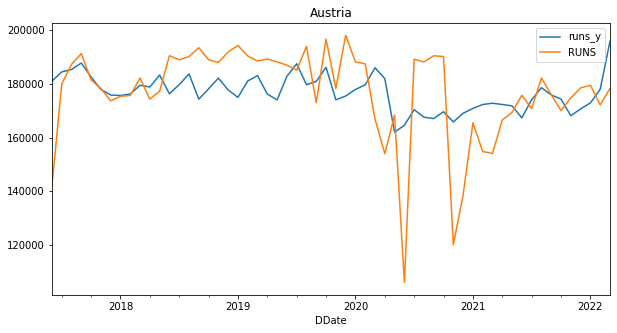

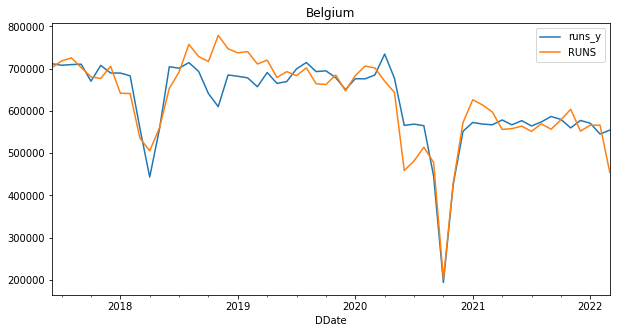

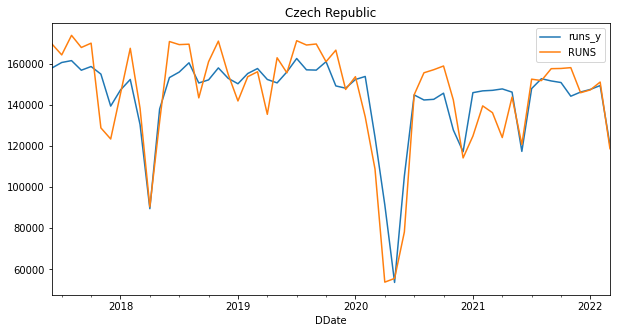

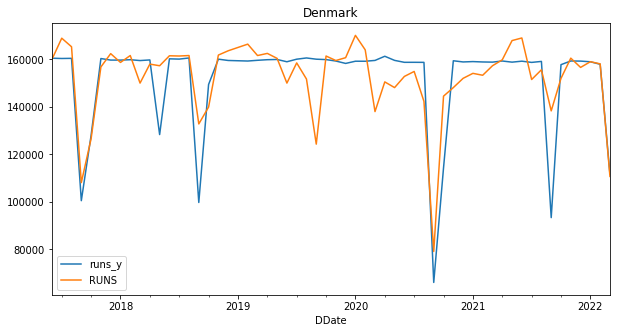

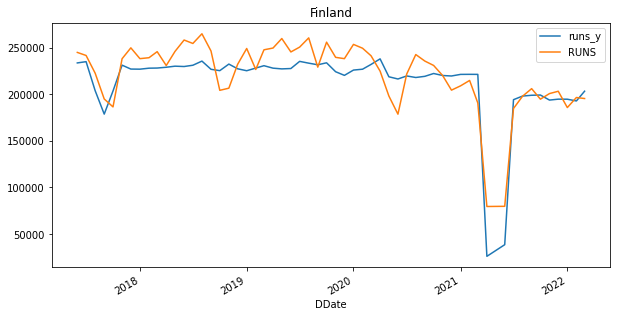

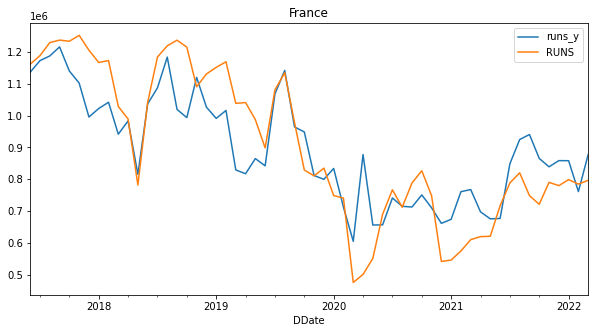

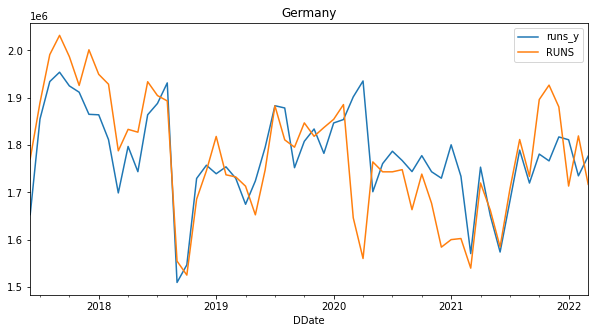

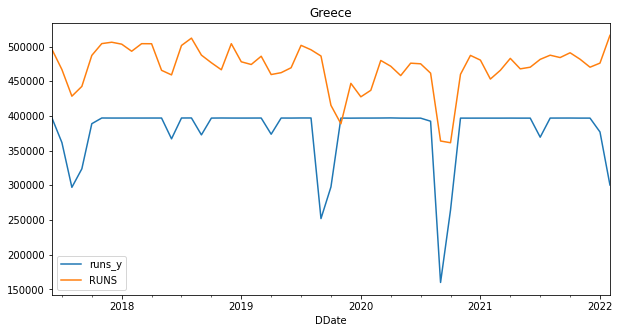

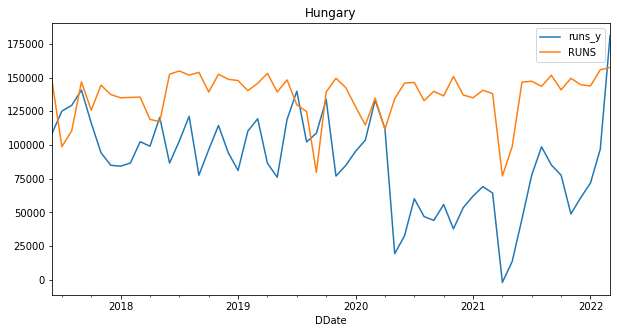

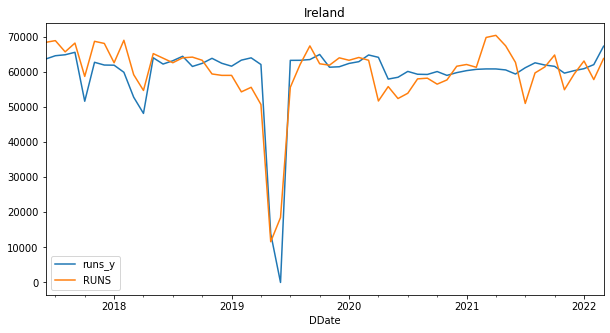

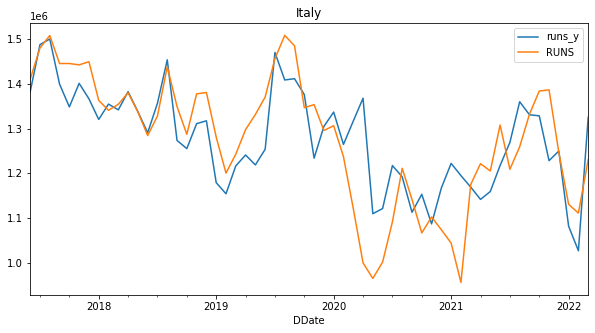

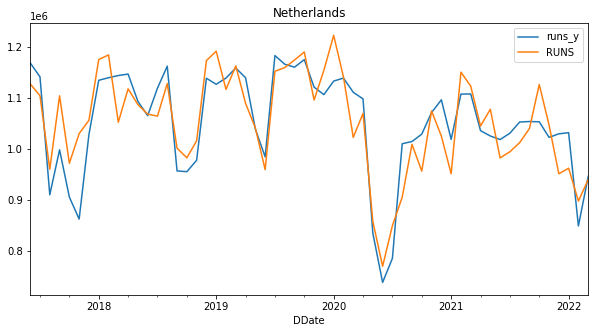

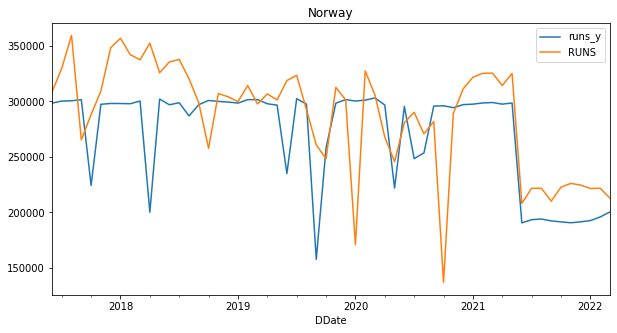

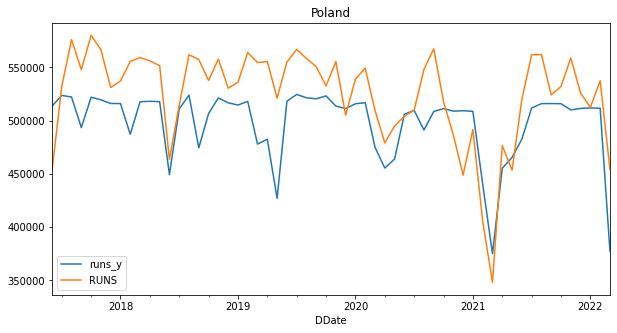

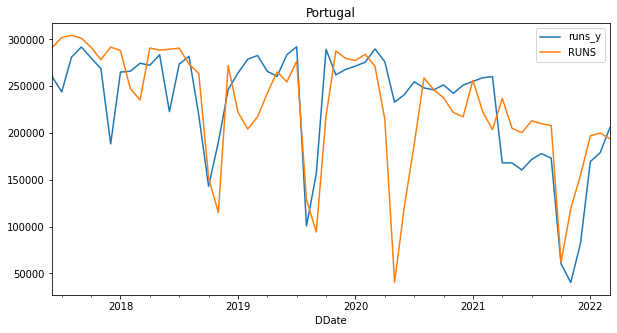

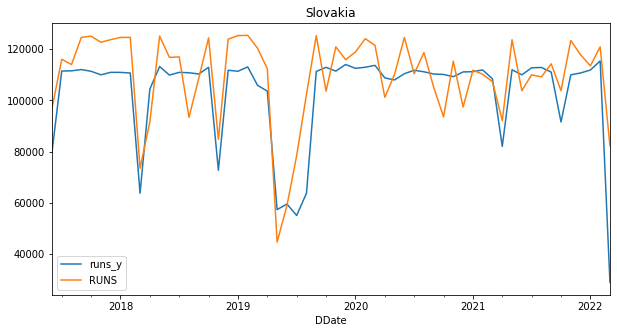

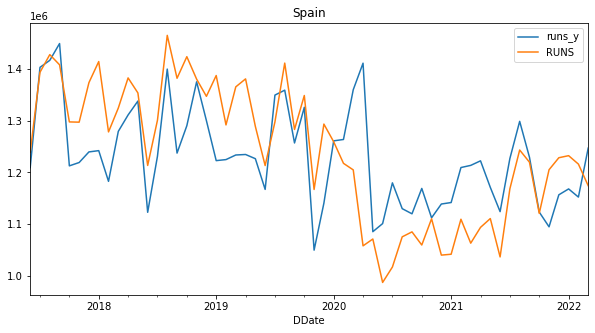

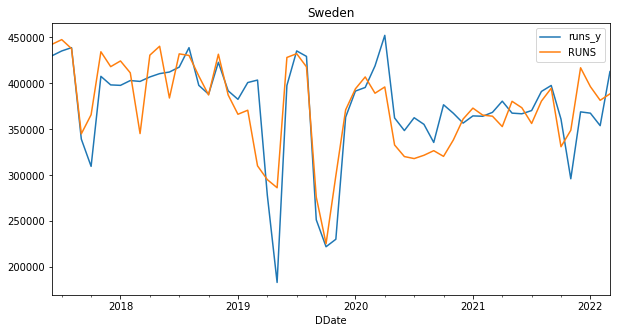

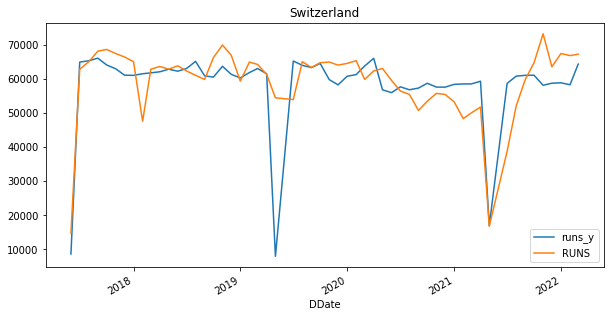

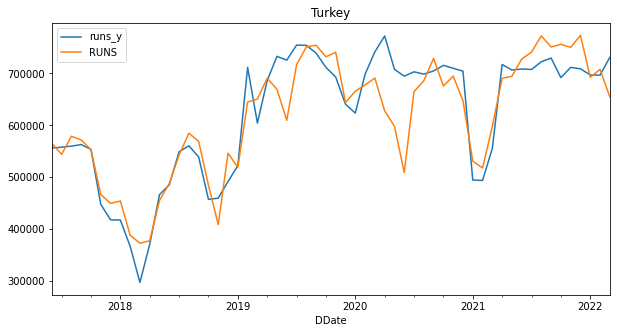

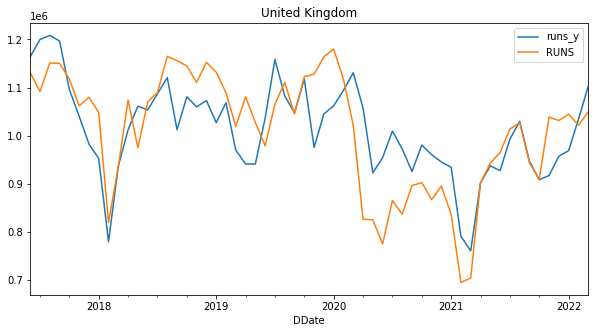

In [88]:
plot_performance(performance)

In [108]:
performance_sum = performance.groupby('DDate')['RUNS', 'runs_y'].sum()

C:\conda\envs\lng\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [109]:
oecd_backtest = performance_sum.merge(correlation_df['runs_z'], how='left', left_index=True, right_index=True)

<AxesSubplot:xlabel='DDate'>

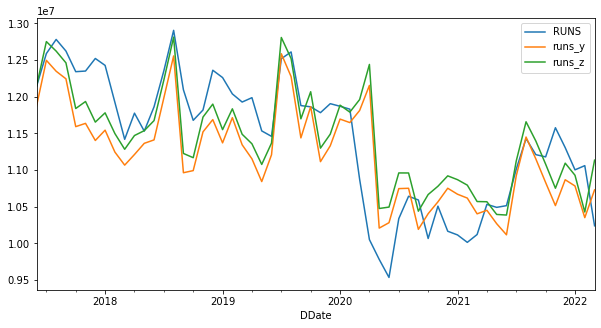

In [110]:
oecd_backtest.plot(kind='line', figsize=(10,5))

In [ ]:
# correct utilsation numbers to max 1 and re run correlation

### optimising modeling at country level

#### NWE

In [76]:
nwe = filter_non_jodi(runs[runs['COUNTRY'].isin(NWE_countries)])

In [85]:
nwe_margin = nwe.merge(margins[['nwecomplex','medcomplex']],how='left', left_on='DDate', right_index=True)

In [86]:
nwe_margin

COUNTRY      DDate   Capacity  kbd_offline  available_capacity  \
83           Belgium 2017-06-01   742000.0          0.0            742000.0   
84           Belgium 2017-07-01   742000.0          0.0            742000.0   
85           Belgium 2017-08-01   742000.0          0.0            742000.0   
86           Belgium 2017-09-01   742000.0          0.0            742000.0   
87           Belgium 2017-10-01   742000.0      35483.0            706517.0   
...              ...        ...        ...          ...                 ...   
1713  United Kingdom 2021-11-01  1225000.0      22000.0           1203000.0   
1714  United Kingdom 2021-12-01  1225000.0          0.0           1225000.0   
1715  United Kingdom 2022-01-01  1225000.0      13548.0           1211452.0   
1716  United Kingdom 2022-02-01  1225000.0          0.0           1225000.0   
1717  United Kingdom 2022-03-01  1225000.0      92258.0           1132742.0   

           RUNS  utilisation  nwecomplex  medcomplex  
83     702500.0       0.9468    5.904091    5.657273  
84     718100.0       0.9678    6.146667    6.478095  
85     725400.0       0.9776    6.431818    6.753636  
86     702700.0       0.9470    6.895238    7.410476  
87     680500.0       0.9632    5.484091    5.885455  
...         ...          ...         ...         ...  
1713  1038500.0       0.8633    1.066818    1.520000  
1714  1031500.0       0.8420    1.308571    2.139048  
1715  1044700.0       0.8624    0.980000    2.542500  
1716  1021900.0       0.8342   -0.819500    3.164500  
1717  1049300.0       0.9263    3.005217    8.132174  

[579 rows x 9 columns]

In [103]:
def get_regression(df, margin):
    country_list = df.COUNTRY.unique()
    for c in country_list:
        print(c)
        df_c = df[df['COUNTRY']==c]
        x = df_c[margin]
        y = df_c['utilisation']

        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()

        print(model.summary())  

In [99]:
get_regression(nwe_margin,'nwecomplex')

Belgium
                            OLS Regression Results                            
Dep. Variable:            utilisation   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     7.978
Date:                Sat, 28 May 2022   Prob (F-statistic):            0.00655
Time:                        13:26:19   Log-Likelihood:                 72.349
No. Observations:                  58   AIC:                            -140.7
Df Residuals:                      56   BIC:                            -136.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8935      0.015     57.742 

C:\conda\envs\lng\lib\site-packages\statsmodels\regression\linear_model.py:1666: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


In [104]:
def get_regression_2(df):
    country_list = df.COUNTRY.unique()
    for c in country_list:
        print(c)
        df_c = df[df['COUNTRY']==c]
        x = df_c[['nwecomplex','medcomplex']]
        y = df_c['utilisation']

        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()

        print(model.summary())  

In [95]:
get_regression_2(nwe_margin)

Belgium
                            OLS Regression Results                            
Dep. Variable:            utilisation   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     4.623
Date:                Sat, 28 May 2022   Prob (F-statistic):             0.0139
Time:                        13:14:20   Log-Likelihood:                 72.993
No. Observations:                  58   AIC:                            -140.0
Df Residuals:                      55   BIC:                            -133.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9120      0.023     40.198 

C:\conda\envs\lng\lib\site-packages\statsmodels\regression\linear_model.py:1666: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


#### MED

In [97]:
med = filter_non_jodi(runs[runs['COUNTRY'].isin(MED_countries)])
med_margin = med.merge(margins[['nwecomplex','medcomplex']],how='left', left_on='DDate', right_index=True)

In [105]:
get_regression(med_margin,'medcomplex')

Austria
                            OLS Regression Results                            
Dep. Variable:            utilisation   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     8.632
Date:                Sat, 28 May 2022   Prob (F-statistic):            0.00479
Time:                        13:27:29   Log-Likelihood:                 60.601
No. Observations:                  58   AIC:                            -117.2
Df Residuals:                      56   BIC:                            -113.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8536      0.026     32.865 

In [106]:
get_regression_2(med_margin)

Austria
                            OLS Regression Results                            
Dep. Variable:            utilisation   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     4.510
Date:                Sat, 28 May 2022   Prob (F-statistic):             0.0154
Time:                        13:27:30   Log-Likelihood:                 60.847
No. Observations:                  58   AIC:                            -115.7
Df Residuals:                      55   BIC:                            -109.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8468      0.028     30.271 

In [109]:
get_regression(med_margin,['available_capacity','medcomplex'])

Austria
                            OLS Regression Results                            
Dep. Variable:            utilisation   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     8.632
Date:                Sat, 28 May 2022   Prob (F-statistic):            0.00479
Time:                        14:07:49   Log-Likelihood:                 60.601
No. Observations:                  58   AIC:                            -117.2
Df Residuals:                      56   BIC:                            -113.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
available_capacity  4.446e-0

In [116]:
model.params

const           0.681782
nwecomplex      0.030801
nwesimple      -0.024808
medcomplex      0.007718
medsimple       0.021741
av_eu_margin    0.007090
dtype: float64

In [117]:
model.rsquared

0.43918002191950534

### optimising france

In [64]:
france = runs[runs['COUNTRY']=='France'].copy()

In [65]:
correlation_france = filter_non_jodi(france.merge(margins, how='left', left_on='DDate', right_index=True))

In [66]:
correlation_france = correlation_france[correlation_france['RUNS'].notnull()].copy().set_index('DDate')

In [58]:
for m in margins_cols:
    x = correlation_france[m]
    y = correlation_france['utilisation']

    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()

    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            utilisation   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     28.24
Date:                Sat, 28 May 2022   Prob (F-statistic):           1.92e-06
Time:                        12:43:33   Log-Likelihood:                 43.086
No. Observations:                  58   AIC:                            -82.17
Df Residuals:                      56   BIC:                            -78.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7088      0.026     27.657      0.0

In [71]:
x = correlation_france[margins_cols]
y = correlation_france['utilisation']

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            utilisation   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     10.38
Date:                Sat, 28 May 2022   Prob (F-statistic):           2.79e-06
Time:                        12:54:36   Log-Likelihood:                 48.016
No. Observations:                  58   AIC:                            -86.03
Df Residuals:                      53   BIC:                            -75.73
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6818      0.048     14.134   

In [100]:
# # optimising params oecd_eu
# for m in margins_cols:
#     x = correlation_df[m]
#     y = correlation_df['utilisation']

#     x = sm.add_constant(x)
#     model = sm.OLS(y, x).fit()

#     print(model.summary())

In [102]:
correlation_df['Y'] = 0.006*correlation_df['nwecomplex'] + 0.0138*correlation_df['medcomplex'] + 0.7915

<AxesSubplot:xlabel='DDate'>

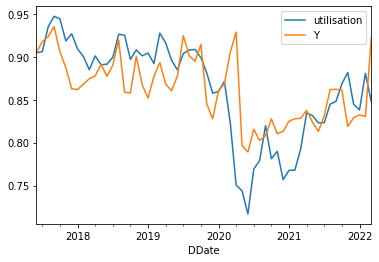

In [103]:
correlation_df[['utilisation','Y']].plot(kind='line')

In [104]:
correlation_df['runs_z'] = correlation_df['Y']*correlation_df['available_capacity']

<AxesSubplot:xlabel='DDate'>

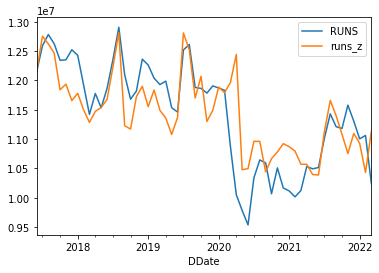

In [106]:
correlation_df[['RUNS','runs_z']].plot(kind='line')

In [107]:
correlation_df.tail()

Capacity  kbd_offline  available_capacity        RUNS  \
DDate                                                                 
2021-11-01  13593971.0     463612.0          13130359.0  11577200.0   
2021-12-01  13593971.0     209404.0          13384567.0  11305700.0   
2022-01-01  13593971.0     465568.0          13128403.0  11002900.0   
2022-02-01  13593971.0    1034052.0          12559919.0  11060200.0   
2022-03-01  13593971.0    1513644.0          12080327.0  10239500.0   

            utilisation  nwecomplex  nwesimple  medcomplex  medsimple  \
DDate                                                                   
2021-11-01     0.881712    1.066818  -2.402727    1.520000  -2.373636   
2021-12-01     0.844682    1.308571  -1.297143    2.139048  -1.547143   
2022-01-01     0.838099    0.980000  -1.719500    2.542500  -1.217500   
2022-02-01     0.880595   -0.819500  -3.443500    3.164500  -1.664000   
2022-03-01     0.847618    3.005217   0.544348    8.132174   1.923043   

            av_eu_margin         Y        runs_z  
DDate                                             
2021-11-01     -0.437909  0.818877  1.075215e+07  
2021-12-01      0.120667  0.828870  1.109407e+07  
2022-01-01      0.117100  0.832466  1.092896e+07  
2022-02-01     -0.552500  0.830253  1.042791e+07  
2022-03-01      2.720957  0.921755  1.113511e+07

array([<AxesSubplot:xlabel='DDate'>, <AxesSubplot:xlabel='DDate'>,
       <AxesSubplot:xlabel='DDate'>, <AxesSubplot:xlabel='DDate'>,
       <AxesSubplot:xlabel='DDate'>], dtype=object)

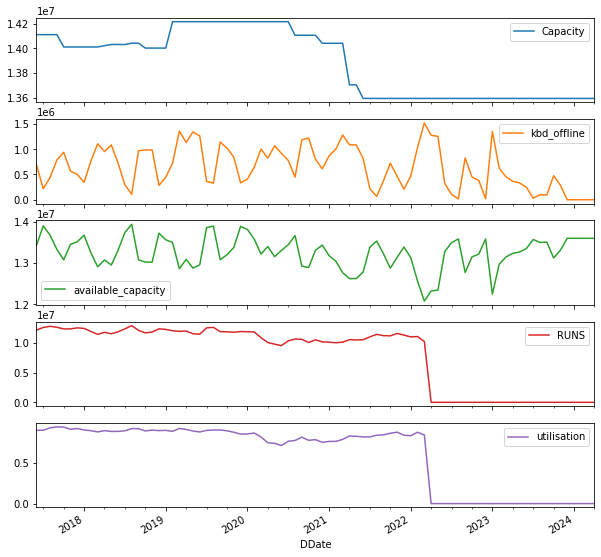

In [177]:
oecd_europe_runs.plot(kind='line', subplots=True, figsize=(10,10))

In [39]:
runs_margins = oecd_hist[['utilisation','nwecomplex', 'nwesimple', 'medcomplex', 'medsimple', 'av_eu_margin']].copy()
correlation_scaled = pd.DataFrame(min_max_scaler.fit_transform(runs_margins.values))
correlation_scaled.index = runs_margins.index

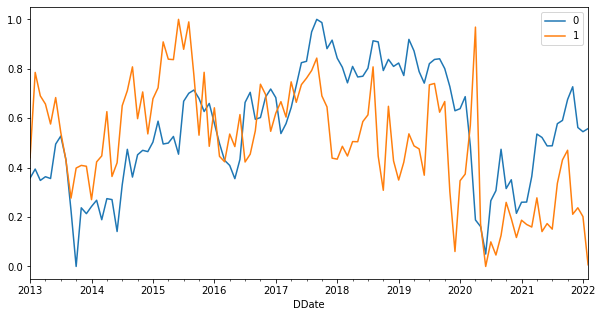

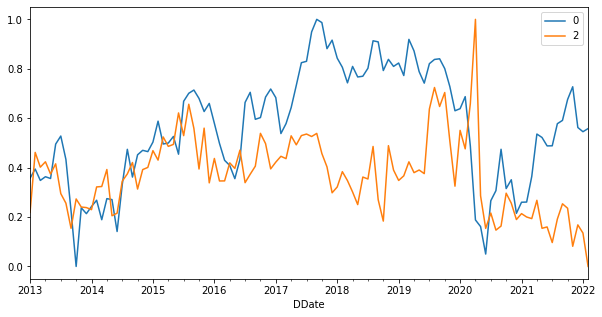

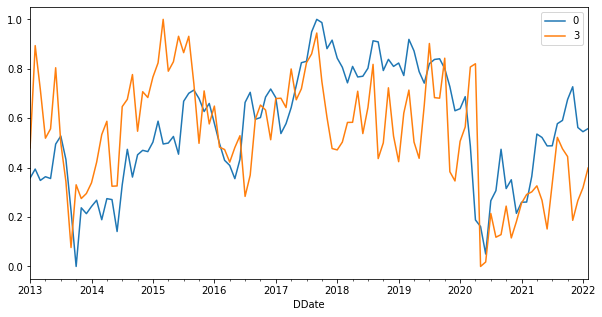

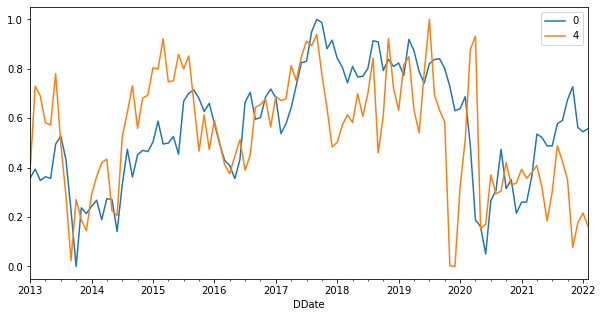

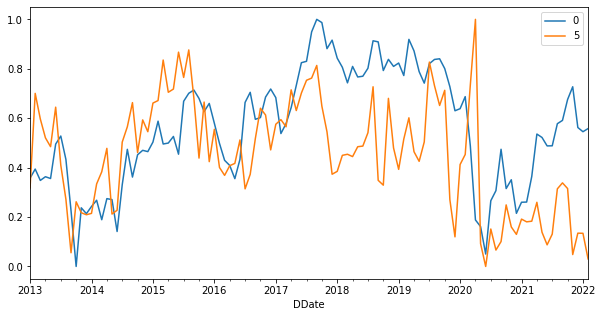

In [409]:
for i in range(1,6):
    correlation_scaled.plot(kind='line', y=[0,i], figsize=(10,5))

In [395]:
def plot_charts(df, title):
    f, axs = plt.subplots(2, len(df.columns.values)-1, figsize=(15,10))
    f.suptitle(title, fontsize=16, y=0.91)
    for i in range(len(df.columns.values)-1):
        sns.regplot(data=df, x=df[df.columns[0]], y=df[df.columns[i+1]], ax=axs[0,i])
        df.plot(kind='line', y=[df.columns.values[0],df.columns.values[i+1]], ax=axs[1,i])

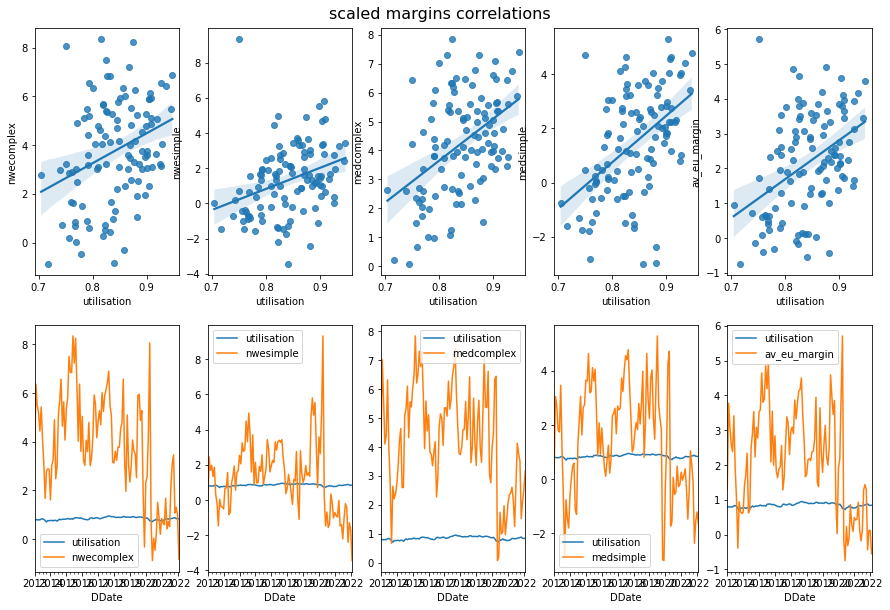

In [398]:
plot_charts(runs_margins, 'scaled margins correlations')

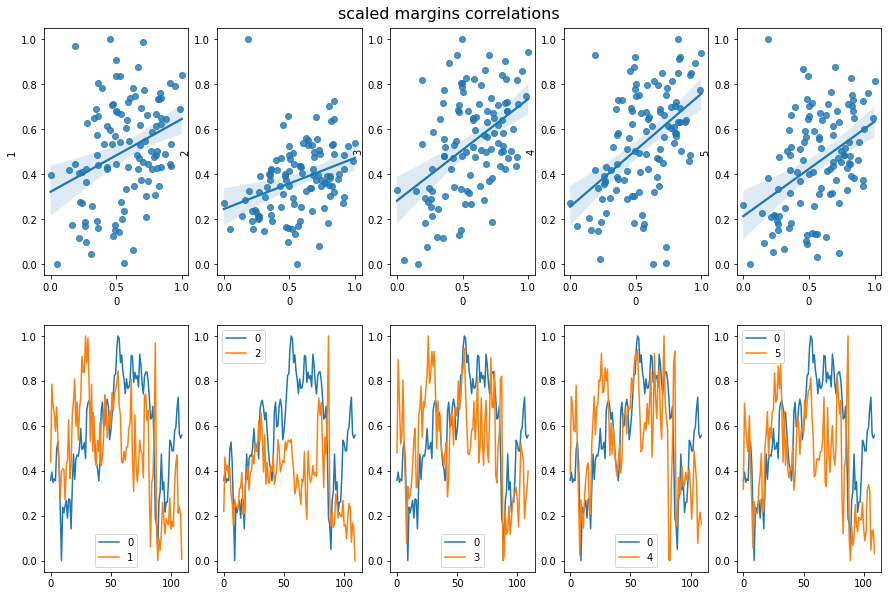

In [397]:
plot_charts(correlation_scaled, 'scaled margins correlations')

<AxesSubplot:xlabel='OUTAGE_DATE'>

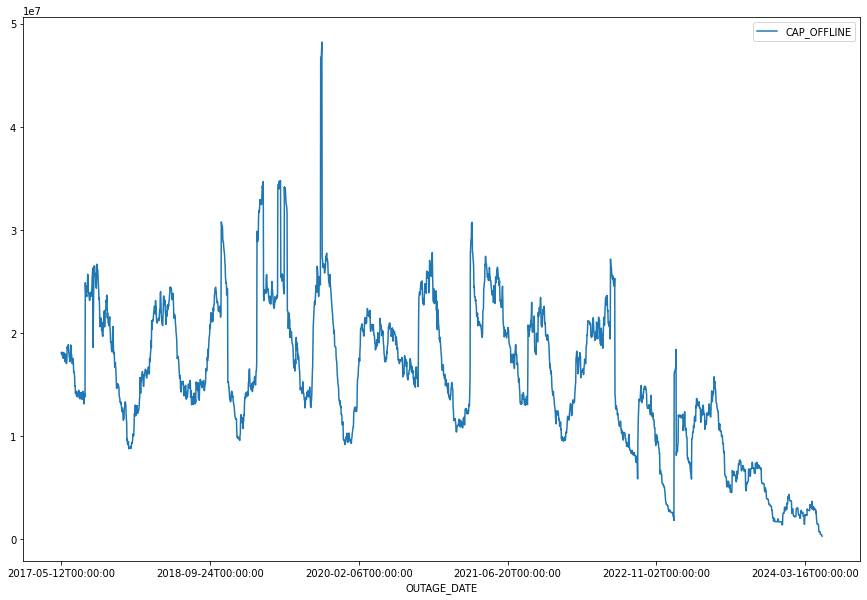

In [40]:
# timeseries of outages
outage_ts = forced_outages.groupby('OUTAGE_DATE').sum('CAP_OFFLINE')
outage_ts.plot(kind='line', figsize=(15,10))

In [49]:
# # timeseries of outages
# outage_ts = forced_outages.groupby(['OUTAGE_DATE', 'EVENT_TYPE']).sum('CAP_OFFLINE').reset_index()
# outage_ts_split = forced_outages.pivot(index='OUTAGE_DATE', columns='EVENT_TYPE', values='CAP_OFFLINE')
# outage_ts_split.plot(kind='area', figsize=(15,10))

In [12]:
duplicates = outages[outages.duplicated(subset=['UNIT_ID','OUTAGE_DATE'], keep=False)].sort_values(['UNIT_ID','OUTAGE_DATE'])
duplicates_cap = outages[outages.duplicated(subset=['UNIT_ID','OUTAGE_DATE', 'CAP_OFFLINE'], keep=False)].sort_values(['UNIT_ID','OUTAGE_DATE','CAP_OFFLINE'])
print(f'1: {len(duplicates)}, 2: {len(duplicates_cap)}')

1: 5988, 2: 4028


In [17]:
duplicates.groupby(['UNIT_ID', 'EVENT_ID', 'OUTAGE_DATE']).mean().to_csv('duplicates.csv')

In [13]:
duplicates.to_csv('duplicates.csv')

In [1]:
#incorrect aggregation and duplicate outages over same month
# outages_monthly_cause[outages_monthly_cause[['UNIT_ID', 'EVENT_ID','DDate']].duplicated(subset=['UNIT_ID','DDate'])]

In [ ]:
# jet model regression
def regress_jodi():
    global df_result
    ctry_list = ['BH','BN','CA','CN','HK','ID','IN','IQ','JP','KR','PH','SA','TH','TW','US']
    df_result = pd.DataFrame(columns={'Region', 'a', 'b'})
    i = 0
    for ctry in ctry_list:
        print('fitting ' + ctry)
        df = get_jodi_JetKero_by_country(ctry)

        if df.empty:
            #Jetkero is not available, use kerosene data instead
            df = get_jodi_Kerosene_by_country(ctry)

        if not df.empty:
            # print(df.head(10))
            x = df['MonthlyConsumption']
            y = df['Demand']
            x = sm.add_constant(x)
            model = sm.OLS(y, x).fit()
            df_result.loc[i] = [ctry, round(model.params.MonthlyConsumption, 4), round(model.params.const, 4)]
            i = i + 1